In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from functools import partial

from huggingface_hub import hf_hub_download
from sae_training.sae_group import SAEGroup

from error_eval import *

from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_analysis.visualizer.data_fns import get_feature_data, FeatureData

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_grad_enabled(False)

In [10]:
# Start by downloading them from huggingface

REPO_ID = "jbloom/GPT2-Small-SAEs"


layer = 6  # any layer from 0 - 11 works here
FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

# this is great because if you've already downloaded the SAE it won't download it twice!
path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [11]:
# We can then load the SAE, dataset and model using the session loader
model, sparse_autoencoder, activation_store = (
    LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
)

sae_group = SAEGroup(sparse_autoencoder['cfg'])
sae = sae_group.autoencoders[0]
sae.load_state_dict(sparse_autoencoder['state_dict'])
sae.eval()

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/home/wesg/research/mats_sae_training/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset is not tokenized! Updating config.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.5

SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [ ]:
def get_saes(layers):
    saes = {}
    for layer in layers:
        REPO_ID = "jbloom/GPT2-Small-SAEs"
        FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"
        path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
        
        model, sparse_autoencoder, activation_store = (
            LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
        )
        
        sae_group = SAEGroup(sparse_autoencoder['cfg'])
        sae = sae_group.autoencoders[0]
        sae.load_state_dict(sparse_autoencoder['state_dict'])
        sae.eval()
        saes[layer] = sae
        
    return saes, model, activation_store

In [12]:
n_batches = 50
tokens = []
for i in range(n_batches):
    batch = activation_store.get_batch_tokens()
    tokens.append(batch)
token_tensor = torch.concat(tokens)

In [15]:
loss_df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
original,4064.000000,3.578372,3.170724,0.000005,0.953547,2.839075,5.492835,17.980644
substitution,4064.000000,3.739995,3.125749,0.000063,1.157730,3.067694,5.703244,17.534052
norm_corrected_substitution,4064.000000,3.743230,3.102552,0.000076,1.194038,3.081092,5.686955,17.403522
l2_error_preserving_substitution,4064.000000,3.641217,3.168659,0.000023,1.049646,2.901369,5.594530,18.170509
cos_preserving_substitution_w_sae_norm,4064.000000,3.654867,3.187913,0.000032,1.021019,2.921666,5.648086,18.170334
cos_preserving_substitution_w_true_norm,4064.000000,3.647698,3.174934,0.000018,1.023215,2.904085,5.593487,19.520374


In [ ]:
def create_ablation_hooks(sae_out, pos=None):
    ablation_hooks = [
        (
            'substitution', 
            partial(reconstruction_hook, sae_out=sae_out, pos=pos)),
        (
            'norm_corrected_substitution', 
            partial(reconstruction_w_norm_correction_hook, sae_out=sae_out, pos=pos)),
        (
            'cos_corrected_substitution', 
            partial(reconstruction_w_cos_correction_hook, sae_out=sae_out, pos=pos)),
        (
            'l2_error_preserving_substitution', 
            partial(l2_error_preserving_perturbation_hook, sae_out=sae_out, pos=pos)),
        (
            'cos_preserving_substitution_w_sae_norm', 
            partial(cos_preserving_perturbation_hook, sae_out=sae_out, pos=pos, preserve_sae_norm=True)),
        (
            'cos_preserving_substitution_w_true_norm', 
            partial(cos_preserving_perturbation_hook, sae_out=sae_out, pos=pos, preserve_sae_norm=False)),
        (
            'zero_ablation',
            partial(zero_ablation_hook, pos=pos)),
        (
            'mean_ablation', 
            partial(mean_ablation_hook, pos=pos))
    ]
    return ablation_hooks

In [15]:
import tqdm
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

dataloader = torch.utils.data.DataLoader(
    token_tensor,
    batch_size=32,
    shuffle=False
)

result_dfs = []
for ix, batch_tokens in enumerate(tqdm.tqdm(dataloader)):
    with torch.inference_mode():
        _, cache = model.run_with_cache(
            batch_tokens, 
            prepend_bos=True,
            names_filter=[sae.cfg.hook_point]
        )
        sae_out, feature_acts, loss, mse_loss, l1_loss, _ = sae(
            cache[sae.cfg.hook_point]
        )
        batch_result_df = run_all_ablations(model, batch_tokens, sae_out, layer=layer)
        
        result_dfs.append(batch_result_df)

100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


In [17]:
rdf = pd.concat(result_dfs)

In [18]:
rdf

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,l2_error_preserving_substitution_kl,cos_preserving_substitution_w_sae_norm_loss,cos_preserving_substitution_w_sae_norm_kl,cos_preserving_substitution_w_true_norm_loss,cos_preserving_substitution_w_true_norm_kl,zero_ablation_loss,zero_ablation_kl,mean_ablation_loss,mean_ablation_kl
0,50256,0,3.278100,3.365619,0.003332,3.377289,0.004148,3.266360,1.961000e-04,3.263537,0.005884,3.316574,0.006864,3.242377,0.002828,23.309206,17.864429,10.861158,5.289989
1,464,1,8.601232,8.597129,0.001808,8.591522,0.001902,8.605782,1.304024e-05,8.595135,0.001831,8.549093,0.001927,8.702059,0.002823,20.028505,10.940558,9.396645,3.150977
2,9317,2,0.065391,0.108487,0.026610,0.099839,0.024297,0.074906,7.407134e-04,0.124818,0.041215,0.053148,0.007667,0.086763,0.006129,14.095943,13.112624,9.932948,9.284626
3,6241,3,0.074480,0.035457,0.035550,0.032797,0.032824,0.066222,1.015712e-03,0.130286,0.020711,0.067821,0.027554,0.163239,0.034232,7.681902,7.178787,4.543427,4.312929
4,416,4,0.000662,0.980144,0.975135,1.081219,1.076154,0.000652,1.166435e-05,0.002779,0.002332,0.452068,0.448086,0.002499,0.002020,17.004158,16.999342,12.962067,12.953915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,886,122,0.304087,0.729397,0.242783,0.796987,0.289680,0.295324,7.011076e-04,0.281711,0.017566,0.252429,0.020240,0.339160,0.008648,6.317708,5.794748,3.048857,2.600669
4060,13,123,0.681232,0.688974,0.036728,0.720074,0.039223,0.656129,6.300174e-04,0.611009,0.025889,0.890247,0.028118,0.651427,0.055443,6.972838,11.668982,3.913292,4.621393
4061,198,124,0.000278,0.000305,0.000006,0.000304,0.000006,0.000272,3.780538e-07,0.000227,0.000007,0.000304,0.000002,0.000305,0.000004,6.972846,6.969745,3.913294,3.910256
4062,198,125,5.149232,4.919920,0.049858,4.945456,0.051100,5.119994,5.705841e-04,5.181639,0.020566,5.154179,0.017636,5.170076,0.016405,22.200348,22.023937,10.023598,7.996298


In [22]:
rdf[[c for c in rdf.columns if 'loss' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
loss,203200.000000,3.569470,3.166067,-0.000000,0.982403,2.784680,5.459197,26.582905
substitution_loss,203200.000000,3.706032,3.107372,0.000002,1.207767,2.982711,5.581646,22.709108
norm_corrected_substitution_loss,203200.000000,3.714515,3.091204,0.000001,1.234312,3.005651,5.585448,21.791985
cos_corrected_substitution_loss,203200.000000,3.572845,3.182829,-0.000000,0.967197,2.781228,5.473478,26.828659
l2_error_preserving_substitution_loss,203200.000000,3.627770,3.154006,-0.000000,1.062622,2.867658,5.517523,25.712482
cos_preserving_substitution_w_sae_norm_loss,203200.000000,3.636407,3.177773,-0.000000,1.044338,2.861130,5.544078,27.080666
cos_preserving_substitution_w_true_norm_loss,203200.000000,3.631243,3.157917,-0.000000,1.063248,2.870862,5.525669,25.303991


In [23]:
rdf[[c for c in rdf.columns if 'kl' in c]].describe().T.iloc[:-2].style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
substitution_kl,203200.000000,0.154157,0.257341,0.000000,0.042858,0.087331,0.169560,7.360687
norm_corrected_substitution_kl,203200.000000,0.162968,0.264985,0.000000,0.046117,0.093507,0.180455,7.115581
cos_corrected_substitution_kl,203200.000000,0.002826,0.005609,-0.000001,0.000626,0.001467,0.003091,0.318359
l2_error_preserving_substitution_kl,203200.000000,0.060838,0.090483,-0.000000,0.018679,0.037722,0.070933,3.958117
cos_preserving_substitution_w_sae_norm_kl,203200.000000,0.068710,0.114083,-0.000000,0.019909,0.040604,0.077457,5.636531
cos_preserving_substitution_w_true_norm_kl,203200.000000,0.064858,0.103807,0.000000,0.019144,0.038964,0.074150,6.669277


In [37]:
rdf['sub_minus_nominal_loss'] = rdf['substitution_loss'] - rdf['loss']

In [40]:
rdf.sort_values('sub_minus_nominal_loss', ascending=False)

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,l2_error_preserving_substitution_kl,cos_preserving_substitution_w_sae_norm_loss,cos_preserving_substitution_w_sae_norm_kl,cos_preserving_substitution_w_true_norm_loss,cos_preserving_substitution_w_true_norm_kl,zero_ablation_loss,zero_ablation_kl,mean_ablation_loss,mean_ablation_kl,sub_minus_nominal_loss
2704,2678,37,4.741143,15.618616,7.360687,15.374580,7.113778,4.861415,0.001080,5.191509,0.011573,4.364326,0.046663,5.219486,0.011358,14.054718,6.644119,10.622816,4.999538,10.877473
1115,247,99,4.990436,13.880573,2.356997,13.852748,2.354004,4.907588,0.017006,4.946668,0.078557,4.993892,0.180125,4.465536,0.136719,18.179268,8.993977,12.964190,4.343980,8.890137
111,4326,111,1.823066,10.615499,3.151180,10.389697,3.058206,1.813610,0.001064,3.432333,0.239699,2.707802,0.102807,2.384263,0.147835,15.591084,6.954307,11.182005,3.402334,8.792434
1935,15073,30,0.224114,8.783925,6.770732,8.101796,6.210496,0.132964,0.040020,1.131358,0.561949,2.769958,1.807969,3.203346,2.284429,24.891499,21.512804,13.137329,10.951005,8.559812
1618,1339,94,5.027034,13.268468,4.162406,13.295370,4.179701,4.921182,0.001257,4.919987,0.047083,7.712759,0.642950,7.044683,0.462775,20.171097,10.853748,12.682885,5.303147,8.241434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,657,15,7.774892,0.238241,3.420618,0.122753,3.673233,8.876784,0.000193,1.550068,0.242695,2.985900,0.052090,2.119798,0.135426,6.972846,15.549669,4.506182,7.232981,-7.536651
854,8646,92,9.808127,0.650292,1.484367,0.353732,1.816421,10.387980,0.000015,3.848040,0.024214,1.733704,0.194168,2.232296,0.116390,6.972850,15.556249,4.506181,7.237299,-9.157835
484,8646,103,10.299988,0.472712,1.246142,0.385881,1.361778,12.292953,0.000042,3.231552,0.061980,10.001309,0.000019,7.285588,0.001858,6.972852,15.556775,4.506180,7.237731,-9.827275
1343,1802,73,10.852107,0.674859,1.818656,0.438941,2.280267,10.438046,0.000119,4.733526,0.036121,8.000130,0.003687,3.529912,0.032396,6.972843,15.555863,4.506179,7.236773,-10.177248


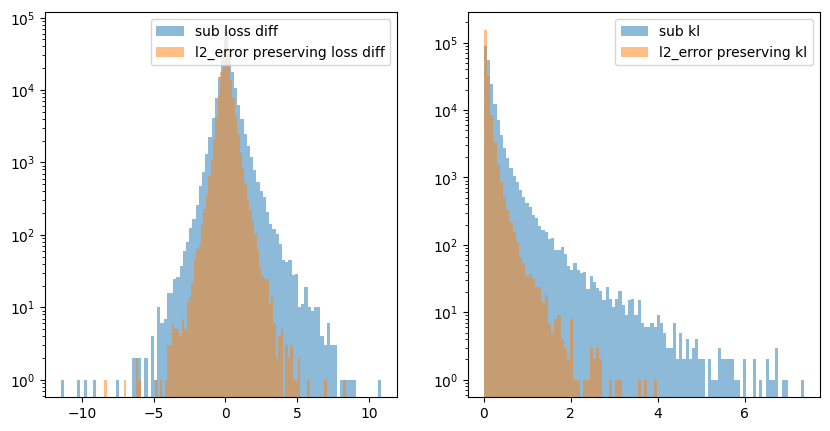

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
ax.hist(rdf['substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='sub loss diff');
ax.hist(rdf['l2_error_preserving_substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='l2_error preserving loss diff');
ax.legend()
ax.set_yscale('log')

kl_max = max(rdf['substitution_kl'].max(), rdf['l2_error_preserving_substitution_kl'].max())
ax = axs[1]
ax.hist(rdf['substitution_kl'], bins=100, alpha=0.5, label='sub kl', range=(0, kl_max));
ax.hist(rdf['l2_error_preserving_substitution_kl'], bins=100, alpha=0.5, label='l2_error preserving kl', range=(0, kl_max));
ax.legend()
ax.set_yscale('log')

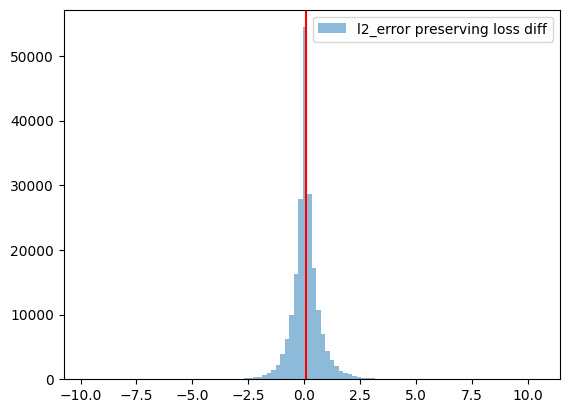

In [32]:
#plt.hist(rdf['substitution_loss'] - rdf['loss'], bins=100, alpha=0.5, label='sub loss diff');
plt.hist(rdf['substitution_loss'] - rdf['l2_error_preserving_substitution_loss'], bins=100, alpha=0.5, label='l2_error preserving loss diff');
plt.legend()
mean_diff = (rdf['substitution_loss'] - rdf['l2_error_preserving_substitution_loss']).mean()
plt.axvline(mean_diff, color='r')
#plt.yscale('log')

In [102]:
loss_by_pos = rdf.groupby('position')[[c for c in rdf.columns if 'loss' in c and 'zero' not in c and 'mean' not in c]].mean()
px.line(loss_by_pos, title="Loss by position").show()

In [70]:
errors = einops.rearrange((act - sae_out)[1:], "batch seq dim -> (batch seq) dim")

In [71]:
# error pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(errors.cpu().numpy())

PCA()

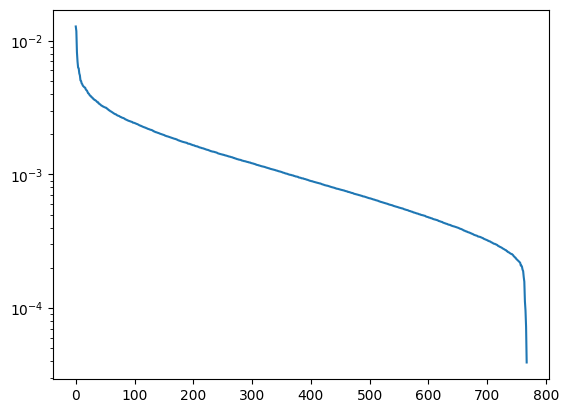

In [82]:
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')